In [1]:
import pandas as pd
import boto3
from track_buses import *
import matplotlib.pyplot as plt

In [2]:
# Load configs
secret_names = ["rt_from", "rt_to", "rt_num", "cta_bus_api_key", "aws_access_key_id", "aws_secret_access_key"]
load_secrets(secret_names)

In [3]:
# Load data from AWS into pandas dataframe
s3_client = boto3.client('s3', 
                         aws_access_key_id=os.environ["aws_access_key_id"], 
                         aws_secret_access_key= os.environ["aws_secret_access_key"])
df = None
headers = ["vid", "from", "start", "to", "end"]
data_file_names = [obj['Key'] for obj in s3_client.list_objects(Bucket='bus-time-lambda-bucket')['Contents'] if '.csv' in obj['Key']]
for data_file_name in data_file_names:
    print("Loading %s" % data_file_name)
    obj = s3_client.get_object(Bucket='bus-time-lambda-bucket', Key=data_file_name)
    lines = [line.split(',') for line in obj['Body'].read().decode('utf-8').split('\n')]
    if df is not None:
        tmp = pd.DataFrame(lines)
        tmp.columns = tmp.iloc[0]
        tmp = tmp[1:]
        tmp['start'] = pd.to_datetime(tmp['start'], format='%Y%m%d %H:%M')
        tmp['end'] = pd.to_datetime(tmp['end'], format='%Y%m%d %H:%M')
        df = pd.concat([df, tmp])
    else:
        df = pd.DataFrame(lines)
        df.columns = df.iloc[0]
        df = df[1:]
        df['start'] = pd.to_datetime(df['start'], format='%Y%m%d %H:%M')
        df['end'] = pd.to_datetime(df['end'], format='%Y%m%d %H:%M')
df = df.dropna()
print("%s rows loaded!" % len(df))

Loading 20240103.csv
Loading 20240104.csv
Loading 20240105.csv
Loading 20240106.csv
Loading 20240107.csv
Loading 20240108.csv
Loading 20240109.csv
1514 rows loaded!


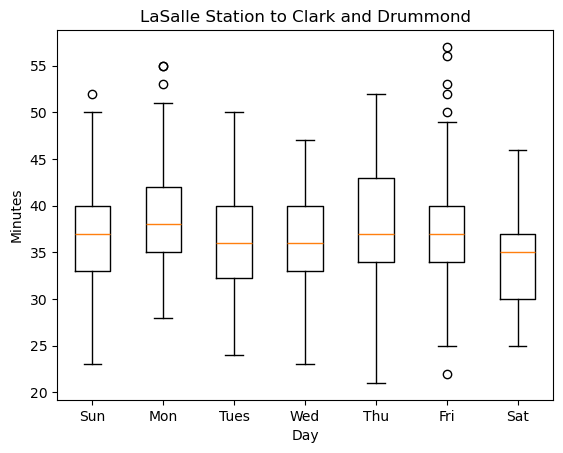

In [27]:
# Analyze data
plt_name = 'LaSalle Station to Clark and Drummond'
rt_from = '17578'
rt_to = '1915'
days_of_week = ['Sun', 'Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat']
filtered_data = df.query("`from` == '%s' and `to` == '%s'" % (rt_from, rt_to))
filtered_data.insert(0, 'day_of_week', filtered_data['start'].transform(lambda x: days_of_week[x.weekday()]))
filtered_data.insert(0, 'travel_time', (filtered_data['end'] - filtered_data['start']).dt.total_seconds()/60)

plt.boxplot([filtered_data.query("`day_of_week` == '%s'" % day)['travel_time'] for day in days_of_week], labels=days_of_week)
plt.title(plt_name)
plt.xlabel('Day')
plt.ylabel('Minutes')
plt.show()